In [18]:
import pandas as pd # import library to read data into dataframe
pd.set_option("display.max_columns", None)
import numpy as np # import numpy library
import re # import library for regular expression
import random # library for random number generation

In [19]:
recipes = pd.read_csv("Dataset/recipes.csv")

# From Understanding to Preparation

In [20]:
# fix name of the column displaying the cuisine
column_names = recipes.columns.values
column_names[0] = "cuisine"
recipes.columns = column_names

# convert cuisine names to lower case
recipes["cuisine"] = recipes["cuisine"].str.lower()

# make the cuisine names consistent
recipes.loc[recipes["cuisine"] == "austria", "cuisine"] = "austrian"
recipes.loc[recipes["cuisine"] == "belgium", "cuisine"] = "belgian"
recipes.loc[recipes["cuisine"] == "china", "cuisine"] = "chinese"
recipes.loc[recipes["cuisine"] == "canada", "cuisine"] = "canadian"
recipes.loc[recipes["cuisine"] == "netherlands", "cuisine"] = "dutch"
recipes.loc[recipes["cuisine"] == "france", "cuisine"] = "french"
recipes.loc[recipes["cuisine"] == "germany", "cuisine"] = "german"
recipes.loc[recipes["cuisine"] == "india", "cuisine"] = "indian"
recipes.loc[recipes["cuisine"] == "indonesia", "cuisine"] = "indonesian"
recipes.loc[recipes["cuisine"] == "iran", "cuisine"] = "iranian"
recipes.loc[recipes["cuisine"] == "italy", "cuisine"] = "italian"
recipes.loc[recipes["cuisine"] == "japan", "cuisine"] = "japanese"
recipes.loc[recipes["cuisine"] == "israel", "cuisine"] = "jewish"
recipes.loc[recipes["cuisine"] == "korea", "cuisine"] = "korean"
recipes.loc[recipes["cuisine"] == "lebanon", "cuisine"] = "lebanese"
recipes.loc[recipes["cuisine"] == "malaysia", "cuisine"] = "malaysian"
recipes.loc[recipes["cuisine"] == "mexico", "cuisine"] = "mexican"
recipes.loc[recipes["cuisine"] == "pakistan", "cuisine"] = "pakistani"
recipes.loc[recipes["cuisine"] == "philippines", "cuisine"] = "philippine"
recipes.loc[recipes["cuisine"] == "scandinavia", "cuisine"] = "scandinavian"
recipes.loc[recipes["cuisine"] == "spain", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "portugal", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "switzerland", "cuisine"] = "swiss"
recipes.loc[recipes["cuisine"] == "thailand", "cuisine"] = "thai"
recipes.loc[recipes["cuisine"] == "turkey", "cuisine"] = "turkish"
recipes.loc[recipes["cuisine"] == "vietnam", "cuisine"] = "vietnamese"
recipes.loc[recipes["cuisine"] == "uk-and-ireland", "cuisine"] = "uk-and-irish"
recipes.loc[recipes["cuisine"] == "irish", "cuisine"] = "uk-and-irish"


# remove data for cuisines with < 50 recipes:
recipes_counts = recipes["cuisine"].value_counts()
cuisines_indices = recipes_counts > 50

cuisines_to_keep = list(np.array(recipes_counts.index.values)[np.array(cuisines_indices)])
recipes = recipes.loc[recipes["cuisine"].isin(cuisines_to_keep)]

# convert all Yes's to 1's and the No's to 0's
recipes = recipes.replace(to_replace="Yes", value=1)
recipes = recipes.replace(to_replace="No", value=0)

# Data Modeling

In [21]:
# import decision trees scikit-learn libraries

from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import itertools

In [22]:
recipes.head()

,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,blue_cheese,blueberry,bone_oil,bourbon_whiskey,brandy,brassica,bread,broccoli,brown_rice,brussels_sprout,buckwheat,butter,buttermilk,cabbage,cabernet_sauvignon_wine,cacao,camembert_cheese,cane_molasses,caraway,cardamom,carnation,carob,carrot,cashew,cassava,catfish,cauliflower,caviar,cayenne,celery,celery_oil,cereal,chamomile,champagne_wine,chayote,cheddar_cheese,cheese,cherry,cherry_brandy,chervil,chicken,chicken_broth,chicken_liver,chickpea,chicory,chinese_cabbage,chive,cider,cilantro,cinnamon,citrus,citrus_peel,clam,clove,cocoa,coconut,coconut_oil,cod,coffee,cognac,concord_grape,condiment,coriander,corn,corn_flake,corn_grit,cottage_cheese,crab,cranberry,cream,cream_cheese,cucumber,cumin,cured_pork,currant,date,dill,durian,eel,egg,egg_noodle,elderberry,emmental_cheese,endive,enokidake,fennel,fenugreek,feta_cheese,fig,fish,flower,frankfurter,fruit,galanga,gardenia,garlic,gelatin,geranium,gin,ginger,goat_cheese,grape,grape_brandy,grape_juice,grapefruit,green_bell_pepper,green_tea,gruyere_cheese,guava,haddock,ham,hazelnut,herring,holy_basil,honey,hop,horseradish,huckleberry,jamaican_rum,japanese_plum,jasmine,jasmine_tea,juniper_berry,kaffir_lime,kale,katsuobushi,kelp,kidney_bean,kiwi,kohlrabi,kumquat,lamb,lard,laurel,lavender,leaf,leek,lemon,lemon_juice,lemon_peel,lemongrass,lentil,lettuce,licorice,lilac_flower_oil,lima_bean,lime,lime_juice,lime_peel_oil,lingonberry,litchi,liver,lobster,long_pepper,lovage,macadamia_nut,macaroni,mace,mackerel,malt,mandarin,mandarin_peel,mango,maple_syrup,marjoram,mate,matsutake,meat,melon,milk,milk_fat,mint,mozzarella_cheese,mung_bean,munster_cheese,muscat_grape,mushroom,mussel,mustard,mutton,nectarine,nira,nut,nutmeg,oat,oatmeal,octopus,okra,olive,olive_oil,onion,orange,orange_flower,orange_juice,orange_peel,oregano,ouzo,oyster,palm,papaya,parmesan_cheese,parsley,parsnip,passion_fruit,pea,peach,peanut,peanut_butter,peanut_oil,pear,pear_brandy,pecan,pelargonium,pepper,peppermint,peppermint_oil,pimenta,pimento,pineapple,pistachio,plum,popcorn,porcini,pork,pork_liver,pork_sausage,port_wine,potato,potato_chip,prawn,prickly_pear,provolone_cheese,pumpkin,quince,radish,raisin,rapeseed,raspberry,raw_beef,red_algae,red_bean,red_kidney_bean,red_wine,rhubarb,rice,roasted_almond,roasted_beef,roasted_hazelnut,roasted_meat,roasted_nut,roasted_peanut,roasted_pecan,roasted_pork,roasted_sesame_seed,romano_cheese,root,roquefort_cheese,rose,rosemary,rum,rutabaga,rye_bread,rye_flour,saffron,sage,sake,salmon,salmon_roe,sassafras,sauerkraut,savory,scallion,scallop,sea_algae,seaweed,seed,sesame_oil,sesame_seed,shallot,sheep_cheese,shellfish,sherry,shiitake,shrimp,smoke,smoked_fish,smoked_salmon,smoked_sausage,sour_cherry,sour_milk,soy_sauce,soybean,soybean_oil,spearmint,squash,squid,star_anise,starch,strawberry,strawberry_jam,strawberry_juice,sturgeon_caviar,sumac,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,vietnamese,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

#  [bamboo_tree] Only Asian and Indian Cuisines

Creating a decision tree for the recipes for just some of the Asian (Korean, Japanese, Chinese, Thai) and Indian cuisines. The reason this action is because the decision tree does not run well when the data is biased towards one cuisine or a group of cuisines, such as in this case, American cuisines. We can exclude the American cuisines from our analysis or just build decision trees for different subsets of the data. Let's go with the second solution.

In [23]:
# select subset of cuisines

asian_indian_recipes = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]
cuisines = asian_indian_recipes["cuisine"]
ingredients = asian_indian_recipes.iloc[:,1:]

bamboo_tree = tree.DecisionTreeClassifier(max_depth=3)
bamboo_tree.fit(ingredients, cuisines)


DecisionTreeClassifier(max_depth=3)

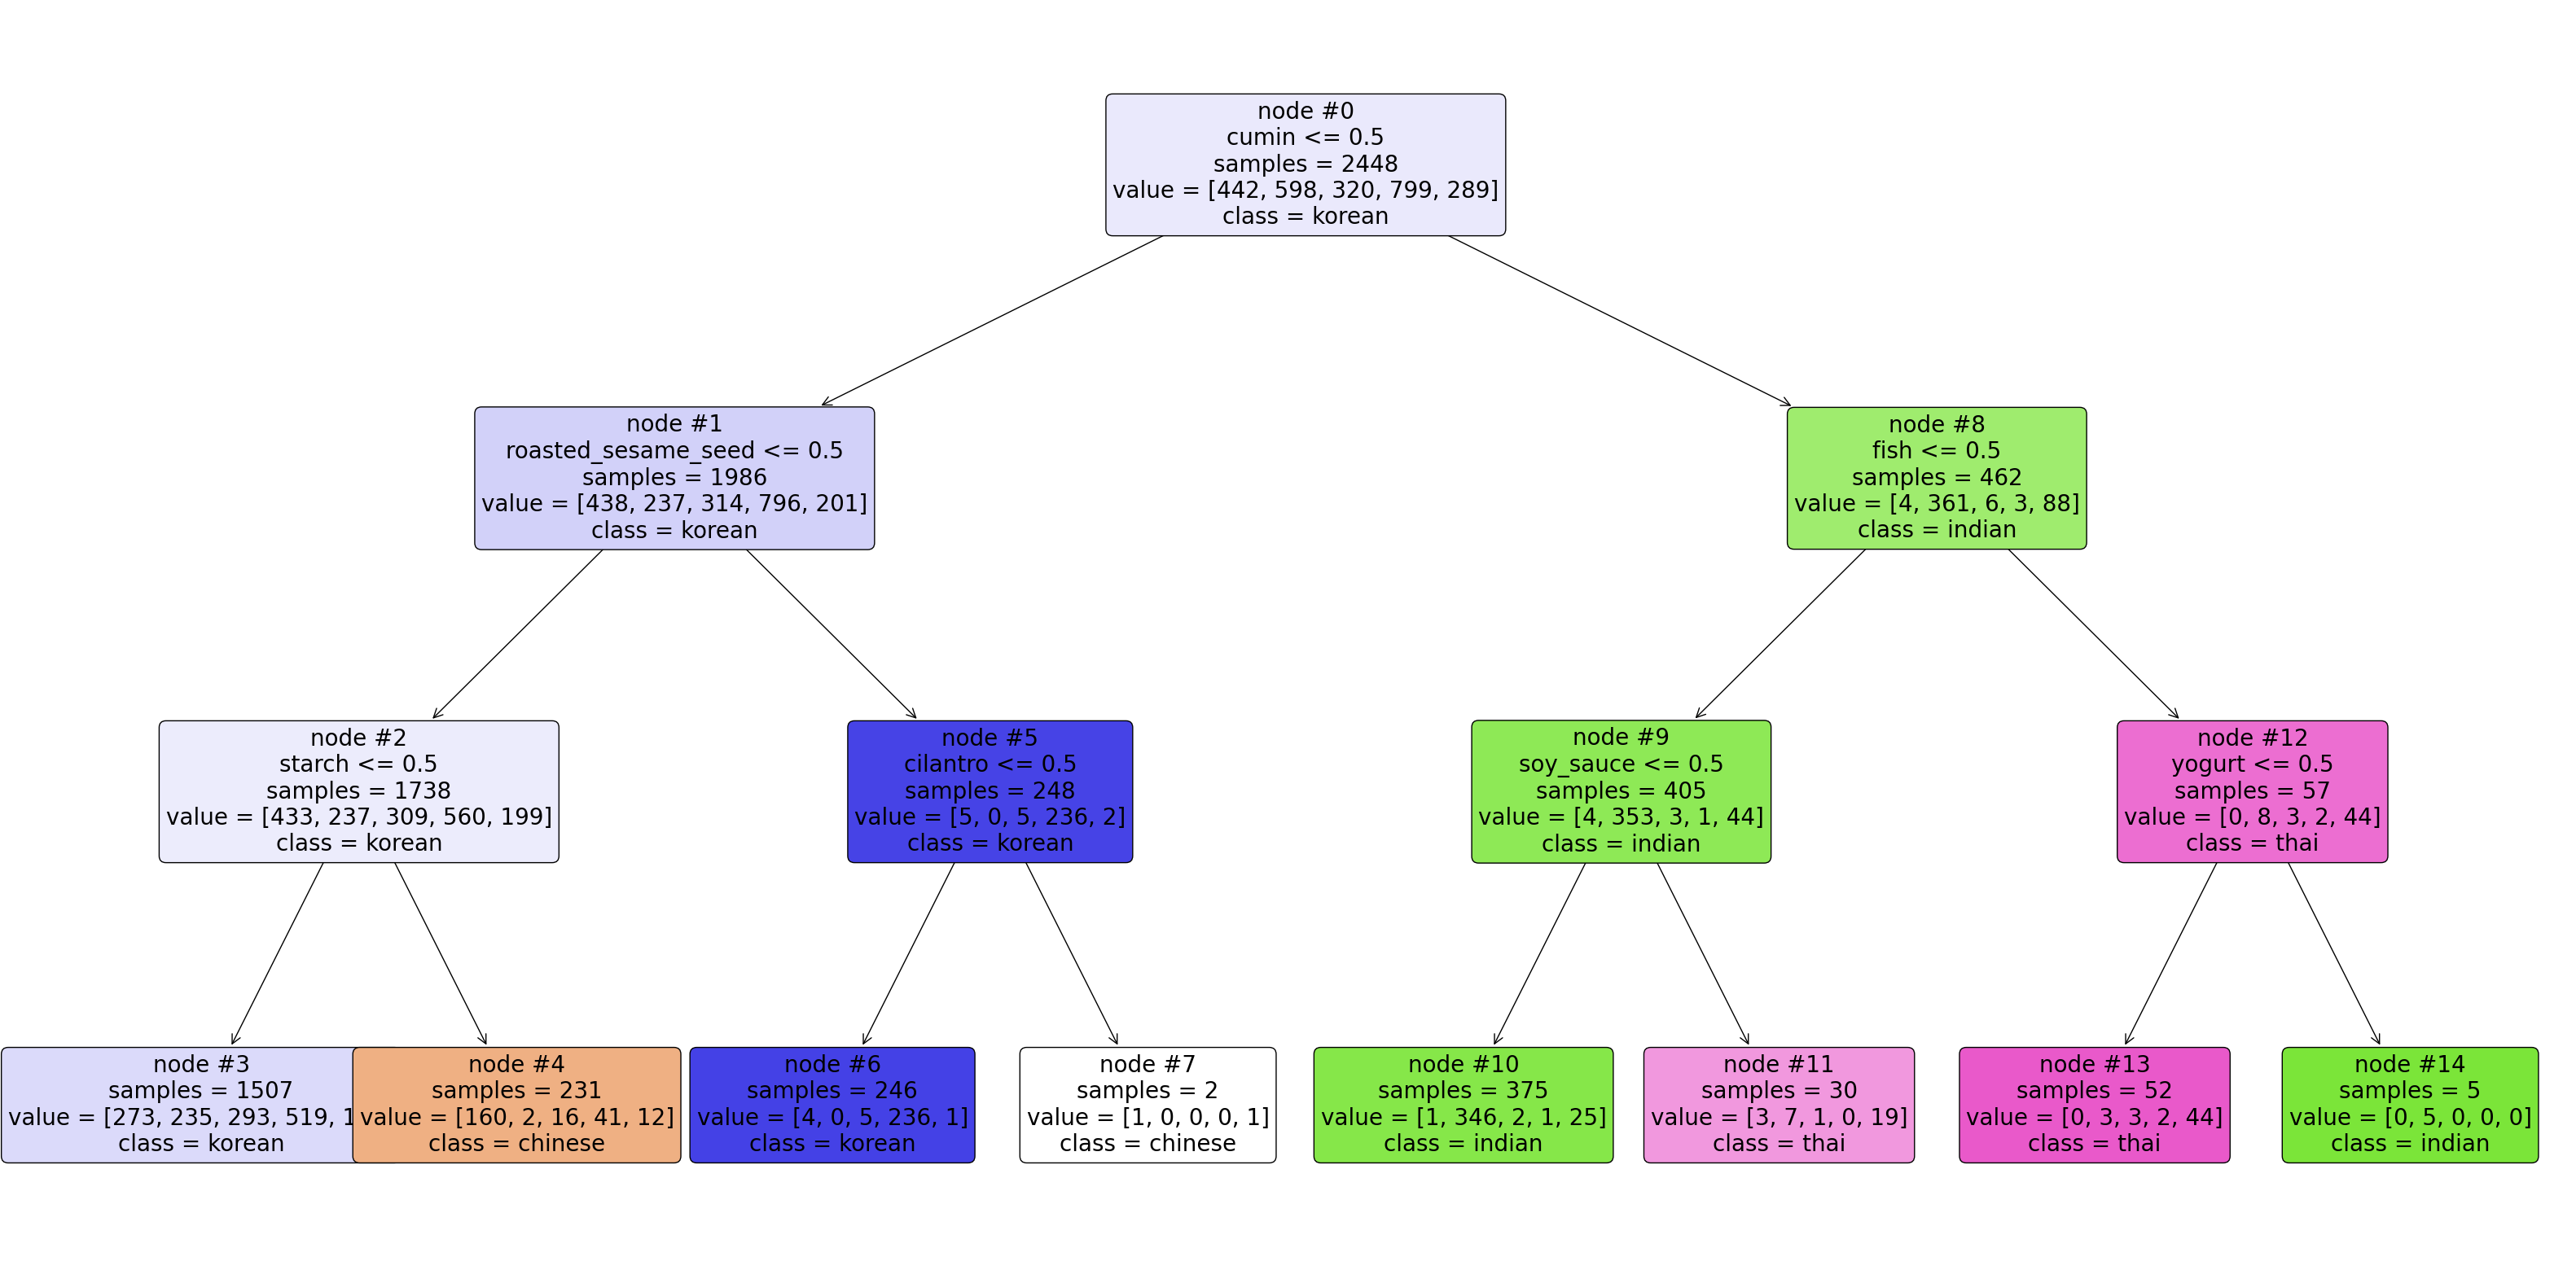

In [24]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(bamboo_tree,
                   feature_names = list(ingredients.columns.values),
                   class_names=np.unique(cuisines),filled=True,
                   node_ids=True,
                   impurity=False,
                   label="all",
                   fontsize=20, rounded = True)
plt.show()

The decision tree learned:
* If a recipe contains *cumin* and *fish* and **no** *yoghurt*, then it is most likely a **Thai** recipe.
* If a recipe contains *cumin* but **no** *fish* and **no** *soy_sauce*, then it is most likely an **Indian** recipe.

# Evaluation
First create a new dataframe using only the data pertaining to the Asian and the Indian cuisines, and let's call the new dataframe **bamboo**.


In [25]:
bamboo = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]

In [26]:
bamboo["cuisine"].value_counts()

korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64

In [27]:
# set sample size
sample_n = 30

In [29]:
# take 30 recipes from each cuisine
random.seed(1234) # set random seed
bamboo_test = bamboo.groupby("cuisine", group_keys=False).apply(lambda x: x.sample(sample_n))

bamboo_test_ingredients = bamboo_test.iloc[:,1:] # ingredients
bamboo_test_cuisines = bamboo_test["cuisine"] # corresponding cuisines or labels

In [30]:
# check that we have 30 recipes from each cuisine
bamboo_test["cuisine"].value_counts()

chinese     30
indian      30
japanese    30
korean      30
thai        30
Name: cuisine, dtype: int64

Now create the training set by removing the test set from the **bamboo** data set, and name the training set **bamboo_train**.


In [31]:
bamboo_test_index = bamboo.index.isin(bamboo_test.index)
bamboo_train = bamboo[~bamboo_test_index]

bamboo_train_ingredients = bamboo_train.iloc[:,1:] # ingredients
bamboo_train_cuisines = bamboo_train["cuisine"] # corresponding cuisines or labels

In [32]:
bamboo_train["cuisine"].value_counts()

korean      769
indian      568
chinese     412
japanese    290
thai        259
Name: cuisine, dtype: int64

Build the decision tree using the training set, **bamboo_train**, and name the generated tree **bamboo_train_tree** for prediction.


In [33]:
bamboo_train_tree = tree.DecisionTreeClassifier(max_depth=15)
bamboo_train_tree.fit(bamboo_train_ingredients, bamboo_train_cuisines)

print("Decision tree model saved to bamboo_train_tree!")

Decision tree model saved to bamboo_train_tree!


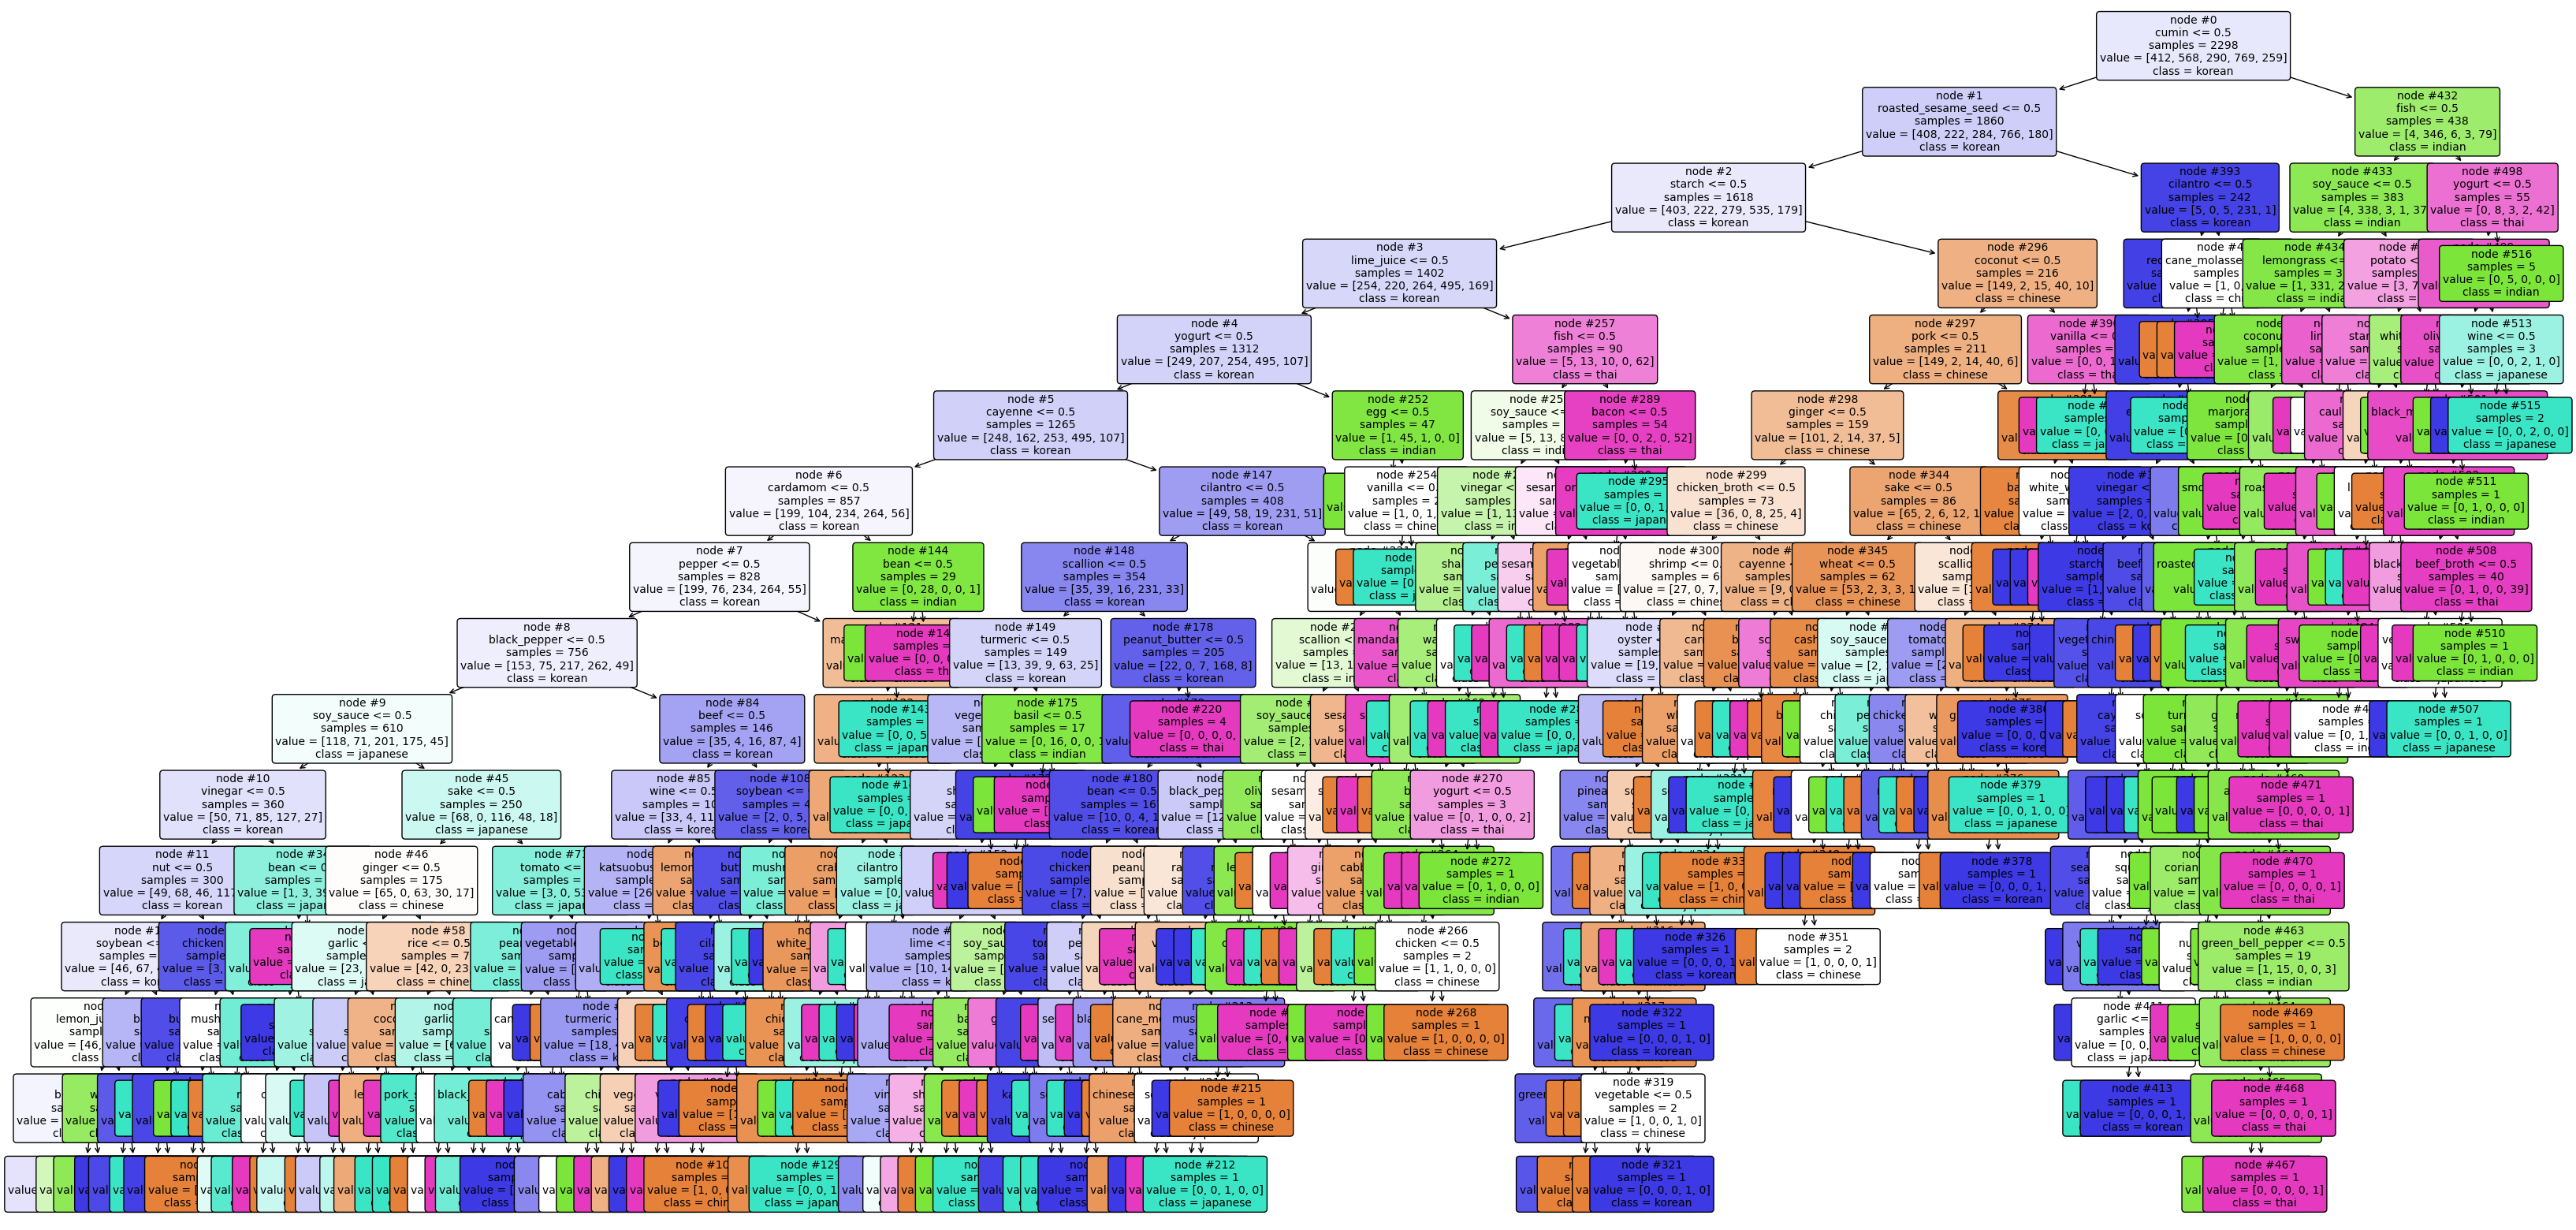

In [34]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(bamboo_train_tree,
                   feature_names=list(bamboo_train_ingredients.columns.values),
                   class_names=np.unique(bamboo_train_cuisines),
                   filled=True,
                   node_ids=True,
                   impurity=False,
                   label="all",
                   fontsize=10, rounded = True)
plt.show()

# Let's test our model on the test data.


In [35]:
bamboo_pred_cuisines = bamboo_train_tree.predict(bamboo_test_ingredients)

To quantify how well the decision tree is able to determine the cuisine of each recipe correctly, we will create a confusion matrix which presents a nice summary on how many recipes from each cuisine are correctly classified. It also sheds some light on what cuisines are being confused with what other cuisines.


So let's go ahead and create the confusion matrix for how well the decision tree is able to correctly classify the recipes in **bamboo_test**.

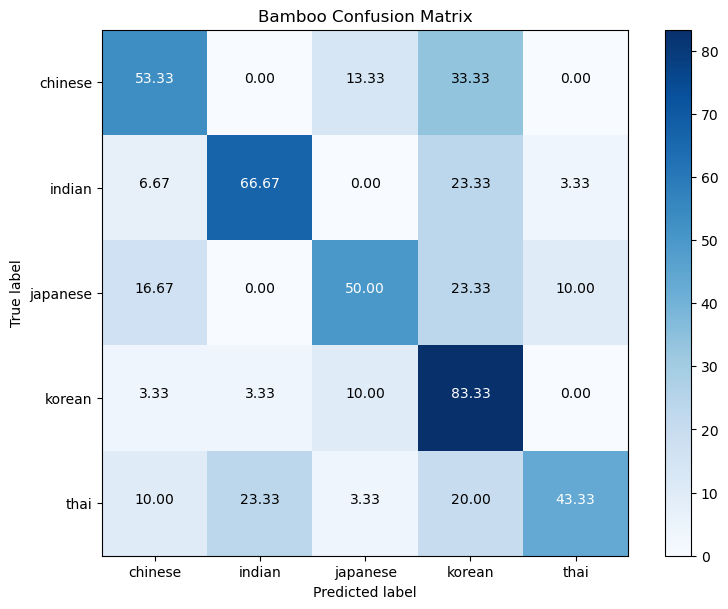

In [36]:
test_cuisines = np.unique(bamboo_test_cuisines)
bamboo_confusion_matrix = confusion_matrix(bamboo_test_cuisines, bamboo_pred_cuisines, labels = test_cuisines)
title = 'Bamboo Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
bamboo_confusion_matrix = (
    bamboo_confusion_matrix.astype('float') / bamboo_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(bamboo_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_cuisines))
plt.xticks(tick_marks, test_cuisines)
plt.yticks(tick_marks, test_cuisines)

fmt = '.2f'
thresh = bamboo_confusion_matrix.max() / 2.
for i, j in itertools.product(range(bamboo_confusion_matrix.shape[0]), range(bamboo_confusion_matrix.shape[1])):
    plt.text(j, i, format(bamboo_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if bamboo_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

The rows represent the actual cuisines from the dataset and the columns represent the predicted ones. Each row should sum to 100%. According to this confusion matrix, we make the following observations:

Using the first row in the confusion matrix, 60% of the Chinese recipes in bamboo_test were correctly classified by our decision tree whereas 37% of the Chinese recipes were misclassified as Korean and 3% were misclassified as Indian.

Using the Indian row, 77% of the Indian recipes in bamboo_test were correctly classified by our decision tree and 3% of the Indian recipes were misclassified as Chinese and 13% were misclassified as Korean and 7% were misclassified as Thai.